  #### An asset pricing model developed in 1992. It expands on the capital asset pricing model (CAPM) by adding size risk and value risk factors to the market risk factor in CAPM
  
#### Factors
    1. Datatime
    2. MKT-RF - excess return  on the market
    3. SMB - Avg return of small minus big portfolios
    4. HML - high minus low avg return value of port - growth portfolios
    5. RMW -  diff between returns of firms  with high and low prob 
    These factors will be considered as X which are independent variable that will be used against MS data (Y)

In [36]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest
import time
#from cvxopt import matrix
import seaborn as sns
import statsmodels.tsa.stattools as ts
from scipy import stats
from scipy.optimize import minimize

In [37]:
df = pd.read_csv("C:/Users/Saloni/Downloads/MORGANSTAN.csv")  

In [38]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-10,41.090000,41.419998,39.560001,40.709999,38.405678,16323200
1,2018-12-11,41.520000,41.880001,40.180000,40.619999,38.320778,13619400
2,2018-12-12,41.110001,41.759998,40.799999,40.810001,38.500023,14207600
3,2018-12-13,40.880001,41.119999,40.330002,40.599998,38.301907,15964600
4,2018-12-14,40.070000,40.939999,39.529999,39.639999,37.396248,17332200


In [39]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [40]:
df['Open'] = df['Open'].astype(float)

In [41]:
df['Date']= pd.to_datetime(df['Date']) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-10,41.090000,41.419998,39.560001,40.709999,38.405678,16323200
1,2018-12-11,41.520000,41.880001,40.180000,40.619999,38.320778,13619400
2,2018-12-12,41.110001,41.759998,40.799999,40.810001,38.500023,14207600
3,2018-12-13,40.880001,41.119999,40.330002,40.599998,38.301907,15964600
4,2018-12-14,40.070000,40.939999,39.529999,39.639999,37.396248,17332200


In [42]:
df
df = df.set_index('Date')
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-10,41.090000,41.419998,39.560001,40.709999,38.405678,16323200
2018-12-11,41.520000,41.880001,40.180000,40.619999,38.320778,13619400
2018-12-12,41.110001,41.759998,40.799999,40.810001,38.500023,14207600


In [43]:
open = df['Open']
rets = open.pct_change()*100
rets = pd.DataFrame(rets)
rets.rename( columns={"Open":"open"}, inplace=True)

In [44]:
import pandas_datareader.data as web

In [45]:
import datetime, re, copy

### Fama-French 3 factor

In [46]:
# get fama/french factor data
# http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
three_fac = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench")
f = copy.copy(three_fac[0])
f.rename( columns={c:re.sub(r'[0-9\-\s]','',c) for c in f.columns}, inplace=True)
f.head()

,MktRF,SMB,HML,RF
Date,,,,
2015-12-10,0.30,0.10,-0.23,0.0
2015-12-11,-2.03,-0.21,-0.04,0.0
2015-12-14,0.29,-1.05,-0.18,0.0
2015-12-15,1.10,0.02,0.82,0.0
2015-12-16,1.47,0.02,-0.65,0.0


In [47]:
m = pd.merge(rets,f,left_index=True,right_index=True)

In [48]:
m.head()

,open,MktRF,SMB,HML,RF
Date,,,,,
2018-12-10,NaN,0.10,-0.17,-1.69,0.01
2018-12-11,1.046483,-0.08,-0.06,-0.39,0.01
2018-12-12,-0.987474,0.68,0.57,-0.22,0.01
2018-12-13,-0.559475,-0.26,-1.50,-0.18,0.01
2018-12-14,-1.981411,-1.89,-0.07,0.53,0.01


In [49]:
# excess returns
m['open_e'] = m.open-m.RF
train = m[:499]
valid = m[500:878]

In [50]:
# ols regression
result = sm.ols( formula = "open_e ~ MktRF + SMB + HML", data=train).fit()

# intercept = alpha
result.params


Intercept    0.066705
MktRF        0.580385
SMB         -0.092200
HML          0.507846
dtype: float64

In [51]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 open_e   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     50.28
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           3.20e-28
Time:                        13:19:09   Log-Likelihood:                -1057.7
No. Observations:                 477   AIC:                             2123.
Df Residuals:                     473   BIC:                             2140.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0667      0.103      0.650      0.516      -0.135       0.268
MktRF          0.5804      0.062      9.353      0.000       0.458       0.702
SMB           -0.0922      0.151     -0.611      0.542      -0.389       0.204
HML            0.5078      0.094      5.404      0.000       0.323       0.693
==============================================================================
Omnibus:                       67.555   Durbin-Watson:                   2.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.095
Skew:                           0.646   Prob(JB):                     2.39e-46
Kurtosis:                       5.983   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5 factor

In [52]:
df2 = pd.read_csv("C:/Users/Saloni/Downloads/F-F_Research_Data_5_Factors_2x3.csv") 

In [53]:
df2

,Date,MktRF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1,196308,5.07,-0.79,1.67,0.40,-0.40,0.25
2,196309,-1.57,-0.48,0.18,-0.76,0.24,0.27
3,196310,2.53,-1.29,-0.10,2.75,-2.24,0.29
4,196311,-0.85,-0.84,1.71,-0.45,2.22,0.27
...,...,...,...,...,...,...,...
681,202004,13.65,2.79,-1.35,2.51,-1.03,0.00
682,202005,5.58,1.92,-4.95,0.71,-3.28,0.01
683,202006,2.46,1.94,-2.22,0.03,0.34,0.01
684,202007,5.77,-3.06,-1.32,0.59,1.02,0.01


In [54]:
open2 = df['Close']

In [55]:
df.reset_index(drop= True,inplace=True)

df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [56]:
open2.reset_index(drop=True, inplace=True)

In [57]:
df2.reset_index(drop=True, inplace=True)

In [58]:
df3 = pd.concat([open2, df2], axis=1)

In [59]:
df3

,Close,Date,MktRF,SMB,HML,RMW,CMA,RF
0,40.709999,196307,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1,40.619999,196308,5.07,-0.79,1.67,0.40,-0.40,0.25
2,40.810001,196309,-1.57,-0.48,0.18,-0.76,0.24,0.27
3,40.599998,196310,2.53,-1.29,-0.10,2.75,-2.24,0.29
4,39.639999,196311,-0.85,-0.84,1.71,-0.45,2.22,0.27
...,...,...,...,...,...,...,...,...
681,NaN,202004,13.65,2.79,-1.35,2.51,-1.03,0.00
682,NaN,202005,5.58,1.92,-4.95,0.71,-3.28,0.01
683,NaN,202006,2.46,1.94,-2.22,0.03,0.34,0.01
684,NaN,202007,5.77,-3.06,-1.32,0.59,1.02,0.01


In [60]:
df3 = df3.dropna()

In [61]:
df3

,Close,Date,MktRF,SMB,HML,RMW,CMA,RF
0,40.709999,196307,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1,40.619999,196308,5.07,-0.79,1.67,0.40,-0.40,0.25
2,40.810001,196309,-1.57,-0.48,0.18,-0.76,0.24,0.27
3,40.599998,196310,2.53,-1.29,-0.10,2.75,-2.24,0.29
4,39.639999,196311,-0.85,-0.84,1.71,-0.45,2.22,0.27
...,...,...,...,...,...,...,...,...
498,63.279999,200501,-2.76,-1.21,2.10,2.72,-1.38,0.16
499,64.019997,200502,1.89,-0.29,1.59,1.48,-0.05,0.16
500,64.059998,200503,-1.97,-1.36,2.14,0.56,1.12,0.21
501,65.000000,200504,-2.61,-4.02,0.01,0.83,-0.90,0.21


In [62]:
# excess returns
df3['open_e'] = df3.Close-df3.RF
train2 = df3[:499]
valid = df3[500:878]

In [63]:
# ols regression
result2 = sm.ols( formula = "open_e ~ MktRF + SMB + HML + RMW + CMA + RF", data=train2).fit()

# intercept = alpha
result2.params


Intercept    47.853683
MktRF         0.088459
SMB          -0.082342
HML           0.006272
RMW           0.067623
CMA           0.206909
RF           -5.690423
dtype: float64

In [64]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 open_e   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     5.105
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           4.23e-05
Time:                        13:19:09   Log-Likelihood:                -1565.3
No. Observations:                 499   AIC:                             3145.
Df Residuals:                     492   BIC:                             3174.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.8537      0.599     79.891      0.000      46.677      49.031
MktRF          0.0885      0.066      1.349      0.178      -0.040       0.217
SMB           -0.0823      0.086     -0.956      0.340      -0.252       0.087
HML            0.0063      0.133      0.047      0.962      -0.255       0.268
RMW            0.0676      0.118      0.571      0.568      -0.165       0.300
CMA            0.2069      0.184      1.122      0.263      -0.156       0.569
RF            -5.6904      1.115     -5.103      0.000      -7.882      -3.499
==============================================================================
Omnibus:                        0.175   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.149
Skew:                           0.042   Prob(JB):                        0.928
Kurtosis:                       2.997   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
class Fama_French_5F:
    
    def fit(X,Y):
        
        invXX = np.linalg.inv(X.transpose()@X)
        beta_hat = invXX@X.transpose()@Y
        y_hat = X@beta_hat
        residuals = Y - y_hat
        T = Y.shape[0]
        N = X.shape
        
        sigma2 = (1/T)*residuals.transpose()@residuals
        sigma = np.sqrt(sigma2)
        varcov_beta_hat = (sigma2)*invXX
        std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))
        R_square = 1 - (residuals.transpose()@residuals)/(T*np.var(Y))
        adj_R_square = 1-(1-R_square)*(T-1)/(T-N[1])
        t_stat = (beta_hat.transpose()-0)/std_beta_hat
        p_val = 1-ss.norm.cdf(t_stat)
        F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
        p_val_F = 1 - ss.f.cdf(F_stat,N[1]-1,T-N[1])
        rmse = np.sqrt(np.mean((Y-y_hat)**2))
#         ar1.metrics(beta_hat,R_square,adj_R_square,p_val,Y,y_hat,rmse)
        return beta_hat,R_square,adj_R_square,p_val,Y,y_hat,rmse

    def metrics(beta_hat,R_square,adj_R_square,p_val,Y,y_hat,rmse):
        
        t = PrettyTable(['Metrics', 'Values'])
        t.add_row(['Beta Values', beta_hat])
        t.add_row(['RMSE',rmse])
        t.add_row(['R-Square',R_square])
        t.add_row(['Adjusted R-Square',adj_R_square])
        t.add_row(['P values',p_val])
        print(t)
        plt.figure(figsize=(10,6))
        plt.plot(Y,'b:', label='Original')
        plt.plot(y_hat,'r', label='Predicted')
        plt.legend(loc='upper left')
        plt.show()

+-------------------+---------------------------------------------------------------+
|      Metrics      |                             Values                            |
+-------------------+---------------------------------------------------------------+
|    Beta Values    |                       [[ 4.82612538e+01]                      |
|                   |                        [ 8.36648058e-02]                      |
|                   |                        [-1.04401768e-01]                      |
|                   |                        [ 2.37282115e-02]                      |
|                   |                        [ 5.97445892e-02]                      |
|                   |                        [ 1.52024149e-01]                      |
|                   |                       [-5.28610285e+00]]                      |
|        RMSE       |                       5.713021097661127                       |
|      R-Square     |                         [[0.0493

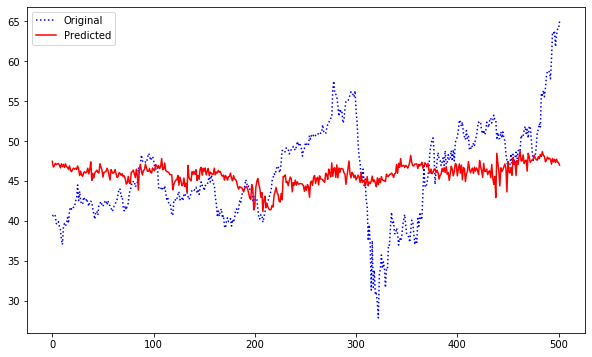

In [71]:
import scipy.stats as ss
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
X_FF = df3[['MktRF','SMB','HML','RMW','CMA','RF']].as_matrix()[1:]
X_FF = np.column_stack([np.ones((len(X_FF),1)),X_FF])
Y_FF = df3[['Close']].as_matrix()[:-1]

beta_hat,R_square,adj_R_square,p_val,Y,y_hat,rmse = Fama_French_5F.fit(X_FF,Y_FF)
Fama_French_5F.metrics(beta_hat,R_square,adj_R_square,p_val,Y,y_hat,rmse)

In [67]:
rmse

5.713021097661127